In [ ]:
from ultralytics import YOLOWorld
import torch

with torch.no_grad():
    # Load the YOLOv8 model
    model = YOLOWorld(
        "/Users/pabloelgueta/Documents/trading-card-assistant/yolov8l-worldv2.pt"
    )
    custom_classes = ["trading_card"]
    model.set_classes(custom_classes)
    model.save("custom_yolo_world.pt")
    model = YOLOWorld("custom_yolo_world.pt")
    # Export the model to CoreML format
    model.export(format="coreml", nms=True)  # creates 'yolov8n.mlpackage'

In [ ]:
from ultralytics import YOLOWorld

model = YOLOWorld("custom_yolo_world.pt")
model.set_classes(["donuts"])
results = model.predict(
    "/Users/pabloelgueta/Documents/trading-card-assistant/scripts/doughnuts-donuts.jpeg",
    save=True,
)

In [ ]:
import coremltools as ct
model = ct.models.MLModel("custom_yolo_world.mlpackage")
spec = model.get_spec()
# spec.description.metadata.userDefined["names"]=list_to_dict_string(classes)
# for k in range(len(classes)):
#    spec.pipeline.models[1].nonMaximumSuppression.stringClassLabels.vector[k]=classes[k]
spec.pipeline.models[1].nonMaximumSuppression.iouThreshold = 0.45  # default 0.45
spec.pipeline.models[1].nonMaximumSuppression.confidenceThreshold = 0.25  # default 0.25

model = ct.models.MLModel(spec, weights_dir=model.weights_dir)
model.save("MyModel.mlpackage")

In [ ]:
from PIL import Image

example_image = Image.open("/Users/pabloelgueta/Documents/trading-card-assistant/scripts/doughnuts-donuts.jpeg")
model = ct.models.MLModel("custom_yolo_world.mlpackage")


# Run inference
results = model.predict(
    {"image":example_image}
)

In [ ]:
import json
import requests
import os

def download_images_from_json(json_file_path):
    # Directory to save the images
    images_dir = 'images'
    os.makedirs(images_dir, exist_ok=True)

    # Function to download an image
    def download_image(url, save_path):
        response = requests.get(url)
        if response.status_code == 200:
            with open(save_path, 'wb') as img_file:
                img_file.write(response.content)
            print(f"Downloaded {save_path}")
        else:
            print(f"Failed to download {url}")

    # Load the JSON data
    with open(json_file_path, 'r') as json_file:
        cards = json.load(json_file)

    # Iterate over each card in the JSON list
    for card in cards:
        # Download the large image for the card
        card_id = card['id']
        image_url = card['images']['large']
        save_path = os.path.join(images_dir, f"{card_id}.png")
        download_image(image_url, save_path)

# Example usage
download_images_from_json('pokemon-tcg-data-master/cards/en/sm115.json')

In [ ]:
def flatten_metadata(metadata):
    flat_metadata = {}

    def _flatten(obj, parent_key=""):
        if isinstance(obj, dict):
            for k, v in obj.items():
                new_key = f"{parent_key}_{k}" if parent_key else k
                _flatten(v, new_key)
        elif isinstance(obj, list):
            for i, v in enumerate(obj):
                new_key = f"{parent_key}_{i}" if parent_key else str(i)
                _flatten(v, new_key)
        else:
            flat_metadata[parent_key] = obj

    _flatten(metadata)
    return flat_metadata

In [ ]:
import json
import os
import chromadb


def vectorize_cards(image_dir, json_file_path):
    # Load the ChromaDB client
    chroma_client = chromadb.PersistentClient(path="chromadb")
    collection = chroma_client.get_collection("pokemon_cards")

    # Create a directory to save the vectorized images
    output_dir = "vectorized_images"
    os.makedirs(output_dir, exist_ok=True)

    # Load the JSON data
    with open(json_file_path, "r") as json_file:
        cards = json.load(json_file)

    # Create a dictionary to map card IDs to their metadata
    card_metadata = card_metadata = {
        card["id"]: flatten_metadata({k: v for k, v in card.items() if k != "images"})
        for card in cards
    }

    # Prepare a list to hold the data to be added to the collection
    data_to_add = []

    # Vectorize each image in the directory
    ids = []
    metadatas = []
    images = []

    for image_file in os.listdir(image_dir):
        if image_file.endswith(".png"):
            card_id = os.path.splitext(image_file)[0]
            image_path = os.path.join(image_dir, image_file)

            # Prepare the data entry
            ids.append(card_id)
            images.append(image_path)
            if card_id in card_metadata:
                metadatas.append(card_metadata[card_id])
            else:
                metadatas.append({})

    # Add all data to the collection at once
    collection.add(ids=ids, metadatas=metadatas, images=images)

    print("Vectorization completed.")


# Example usage
vectorize_cards("images", "pokemon-tcg-data-master/cards/en/sm115.json")

In [ ]:
chroma_client = chromadb.PersistentClient(path="chromadb")
collection = chroma_client.get_collection("pokemon_cards")

results = collection.query(
    query_images=[
        "/Users/pabloelgueta/Documents/trading_card_detection/cropped_images/frame_225_crop_4.jpg"
    ], n_results=3
)

print("Query Results:", results)


In [ ]:
def vectorize_image(url: str):
    import requests

    # Define the endpoint and parameters
    endpoint = "https://pokemon-cards.cognitiveservices.azure.com/computervision/retrieval:vectorizeImage"
    api_version = "2024-02-01"
    model_version = "2023-04-15"
    subscription_key = "b365927a9ad0473fa1d4054ecd6a77c8"

    # Define the headers
    headers = {
        "Content-Type": "application/json",
        "Ocp-Apim-Subscription-Key": subscription_key,
    }

    # Define the data payload
    data = {
        "url": url
    }

    # Make the POST request
    response = requests.post(
        f"{endpoint}?api-version={api_version}&model-version={model_version}",
        headers=headers,
        json=data,
    )

    # Print the response
    print(response.status_code)
    print(response.json())
    response = response.json()
    return response["vector"]

# Example usage


In [ ]:
from chromadb import Documents, EmbeddingFunction, Embeddings


class MyEmbeddingFunction(EmbeddingFunction):
    def __call__(self, input) -> Embeddings:
        return [vectorize_image(image) for image in input]


In [ ]:
import os
files = os.listdir("/Users/pabloelgueta/Documents/trading_card_detection/images")
files = [
    os.path.join("/Users/pabloelgueta/Documents/trading_card_detection/images", f)
    for f in files
    if f.lower().endswith(".png")
]

In [ ]:
import faiss
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import cv2
import json
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import supervision as sv

In [ ]:

# Load the model
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

# Select the device
device = torch.device("cpu")

# Move the model to the selected device
dinov2_vits14.to(device)

print(f"Model loaded on {device}")

In [ ]:
transform_image = T.Compose(
    [T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])]
)


def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

In [ ]:
def create_index(files: list) -> faiss.IndexFlatL2:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    index = faiss.IndexFlatL2(384)

    all_embeddings = {}

    with torch.no_grad():
        for i, file in enumerate(files):
            print(f"Processing file {i+1}/{len(files)}: {file}")
            embeddings = dinov2_vits14(load_image(file).to(device))

            embedding = embeddings[0].cpu().numpy()

            all_embeddings[file] = np.array(embedding).reshape(1, -1).tolist()

            index.add(np.array(embedding).reshape(1, -1))

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    faiss.write_index(index, "data.bin")

    return index, all_embeddings

In [ ]:
data_index, all_embeddings = create_index(files)

In [ ]:
import uuid
from langgraph_main import _print_event, part_1_graph
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Pokemon Trainer"
thread_id = str(uuid.uuid4())

config = {
    "configurable": {

        "thread_id": thread_id,
    }
}
_printed = set()

events = part_1_graph.stream(
    {
        "messages": (
            "user",
            "Just use the card identify tool",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    _print_event(event, _printed)

In [ ]:
from identify_cards import trigger_crop
trigger_crop()

In [ ]:
from transformers import pipeline
import torch

device = "mps"

classifier = pipeline(
    "audio-classification", model="MIT/ast-finetuned-speech-commands-v2", device=device
)

In [ ]:
from transformers.pipelines.audio_utils import ffmpeg_microphone_live


def launch_fn(
    wake_word="marvin",
    prob_threshold=0.5,
    chunk_length_s=2.0,
    stream_chunk_s=0.25,
    debug=True,
):
    if wake_word not in classifier.model.config.label2id.keys():
        raise ValueError(
            f"Wake word {wake_word} not in set of valid class labels, pick a wake word in the set {classifier.model.config.label2id.keys()}."
        )

    sampling_rate = classifier.feature_extractor.sampling_rate

    mic = ffmpeg_microphone_live(
        sampling_rate=sampling_rate,
        chunk_length_s=chunk_length_s,
        stream_chunk_s=stream_chunk_s,
    )

    print("Listening for wake word...")
    for prediction in classifier(mic):
        prediction = prediction[0]
        if debug:
            print(prediction)
        if prediction["label"] == wake_word:
            if prediction["score"] > prob_threshold:
                return True

In [ ]:
launch_fn()

In [ ]:
classifier.model.config.id2label

In [ ]:
from IPython.display import Audio

from audio_commands import synthesise

audio = synthesise(
    "Hugging Face is a company that provides natural language processing and machine learning tools for developers."
)

Audio(audio, rate=16000)

In [ ]:
import torch
torch.mps.empty_cache()

In [ ]:
from core import similarity_search

cropped_images = [
    "/Users/pabloelgueta/Documents/trading-card-assistant/cropped_images/frame_90_crop_0.jpg",
    "/Users/pabloelgueta/Documents/trading-card-assistant/cropped_images/frame_96_crop_1.jpg"
]
image_dir = "/Users/pabloelgueta/Documents/trading-card-assistant/images"
json_file_path = "/Users/pabloelgueta/Documents/trading-card-assistant/pokemon-tcg-data-master/cards/en/"

processor = similarity_search.SimilaritySearch(image_dir, json_file_path)




In [27]:
import os.path
file_path = '/Users/pabloelgueta/Documents/trading-card-assistant/images/sm115-8.png'
base_name = os.path.splitext(os.path.basename(file_path))[0]
print(base_name)

sm115-8


In [33]:
def get_specific_inner_dict(outer_dict, outer_key):
    if outer_key in outer_dict:
        return outer_dict[outer_key]
    else:
        return None

metadata = get_specific_inner_dict(processor.all_metadata, base_name)
print(metadata)

None


In [30]:
metadata = processor.search_metadata(base_name)
print(metadata)

{}


[[{'file': '/Users/pabloelgueta/Documents/trading-card-assistant/images/sm115-8.png', 'metadata': {}}], [{'file': '/Users/pabloelgueta/Documents/trading-card-assistant/images/sm115-9.png', 'metadata': {}}]]


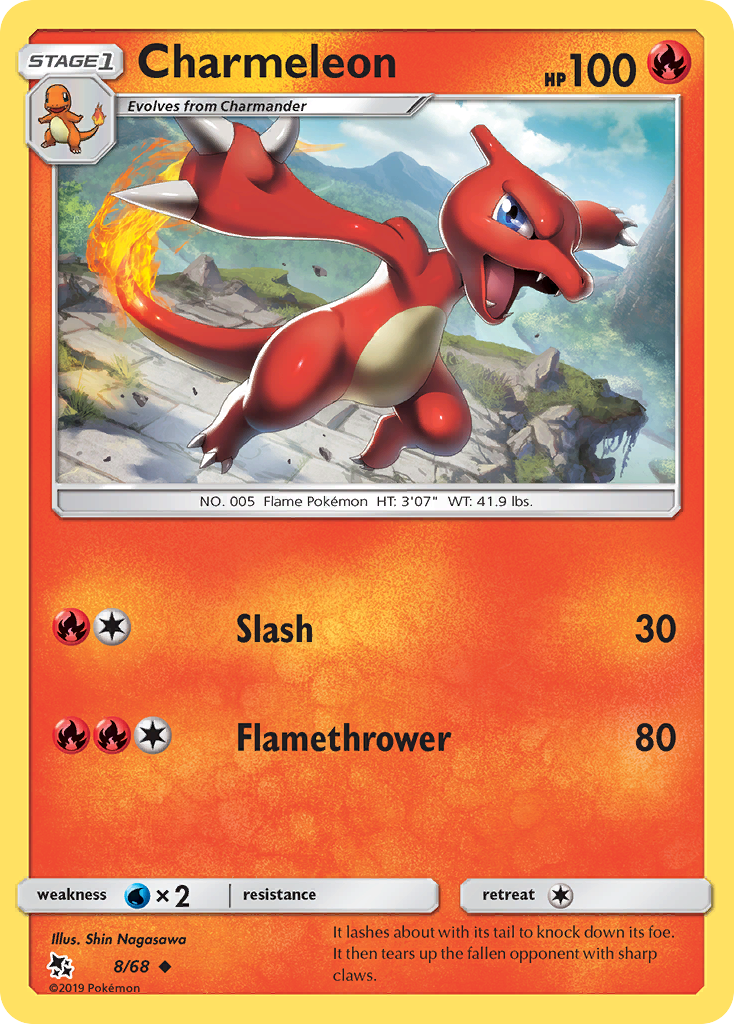

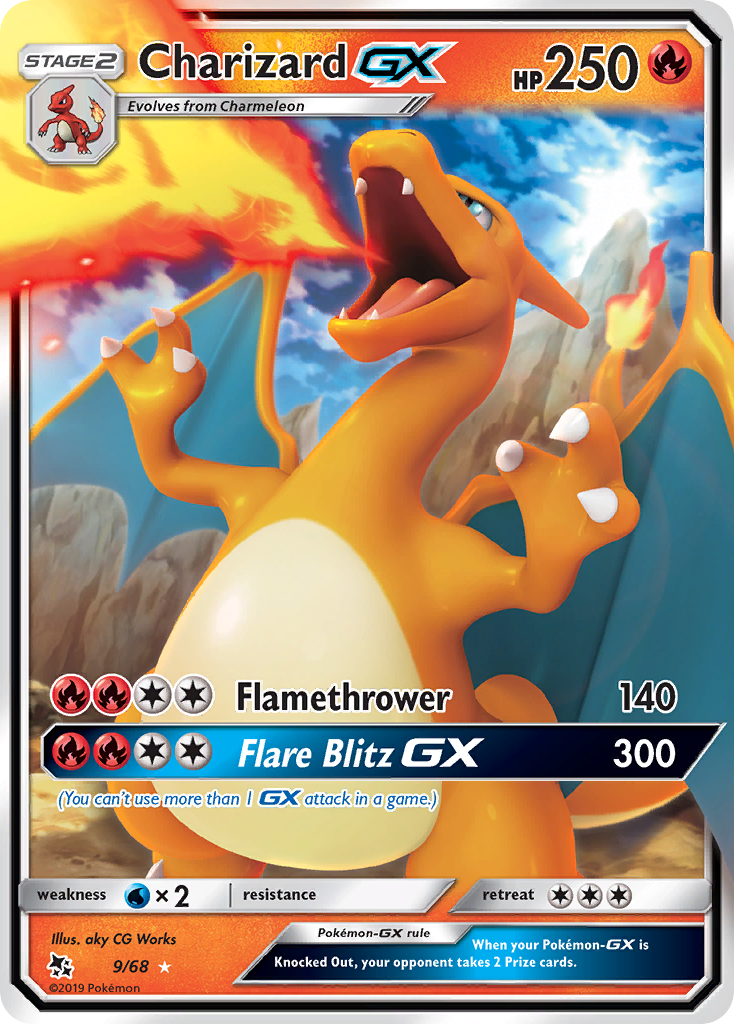

In [21]:
results = processor.process_search_file(cropped_images)
print(results)
from IPython.display import display, Image
file_paths = []

# Loop over each inner list in the data
for inner_list in results:
    # Each inner list contains a single dictionary, so we get that dictionary
    dict_item = inner_list[0]
    # Extract the 'file' value from the dictionary and append it to our list
    file_paths.append(dict_item['file'])

# List of image paths
image_paths = results

# Display images side by side
for image_path in file_paths:
    display(Image(filename=image_path), display_id=True)